In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob

In [2]:
def get_processed_image(image_path, trial, process_name, invert = False):
    filename = os.path.basename(image_path)
    image =  cv2.imread(f"./output/trial_{trial}/processed_images/masks/{process_name}/{os.path.basename(image_path)}", cv2.IMREAD_GRAYSCALE)
    
    if invert:
        image = cv2.bitwise_not(image)
        
    return image

def get_subdirectories(directory):
    return [f.path for f in os.scandir(directory) if f.is_dir()]

def get_process_names(directory):
    return [os.path.basename(f) for f in get_subdirectories(directory)]

def load_images_for_given_process(image_path, trial_number, process_name):
    """
        Load images from the given filenames. Returns raw image and the processed image.
        
        The processed image is inverted so that the lumen/stroma is black and the membrane as white.
        This is to aid in the contouring process, which sees the area of the image as the area within the contour.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    p_image = cv2.imread(f"./output/trial_{trial_number}/processed_images/masks/{process_name}/{os.path.basename(image_path)}", cv2.IMREAD_GRAYSCALE)
    

    return image, cv2.bitwise_not(p_image)


# Load the data from vaclav

In this data, you will find the following columns:
- strip: The strip number of the image, isolated from the image name. This is the unique identifier for each image.
- grana_height: The height in nm of the grana, maximum value of outer membrane to outer membrane distance
- num_lumen: The number of lumen identified in the grana
- repeat_distance: The distance between lumen to lumen in nm

In [3]:
# Load the data, from output\trial_1\vaclav_9_data.csv

data = pandas.read_csv("./output/trial_1/vaclav_9_data.csv")
data.head()

data.columns

Index(['strip', 'grana_height', 'num_lumen', 'repeat_distance'], dtype='object')

In [4]:
def get_human_data(image_filename:str, data_filename:str) -> dict:
    """
    Create a function that returns the row corresponding to the given strip, given the 
    strip filename.
    It will isolate the strip number from the filename and return the corresponding row
    from the dataframe as a dict.
    
    filename: strip_134.png for example would retrieve the df row for strip 134.
    
    output_dict: { 
        'strip': 134, 
        'grana_height': 87.67,
        'num_lumen': 4,
        'repeat_distance': 21.91750}
        
    Adds in the data_filename , so that the data can be reloaded if needed.
    """
    
    data = pandas.read_csv(data_filename)

    strip_number = int(image_filename.split("_")[1].split(".")[0])
    
    human_data = data[data['strip'] == strip_number].to_dict(orient='records')[0]
    
    human_data['data_filename'] = data_filename
    
    return human_data


In [5]:
#Test it
image_name = "strip_161.png"
data_filename = "./output/trial_1/vaclav_9_data.csv"

human_data = get_human_data(image_name, data_filename)

expected_output = {'strip': 161, 'grana_height': 136.34, 'num_lumen': 8, 'repeat_distance': 17.0425, 'data_filename': './output/trial_1/vaclav_9_data.csv'}

if (human_data == expected_output):
    print("Test passed")
else:
    print("Test failed: ", human_data)

Test passed


# Display the process names for easy reference

In [6]:
trial_number = 1
process_names = get_process_names(f"output/trial_{trial_number}/processed_images/masks")
images = glob.glob(f"output/trial_{trial_number}/rois/*.png")

for process_name in process_names:
    print(process_name)


adaptive_gaussian_thresholding_blurred_equalized
adaptive_gaussian_thresholding_blurred_not_equalized
adaptive_gaussian_thresholding_not_blurred_equalized
adaptive_gaussian_thresholding_not_blurred_not_equalized
adaptive_thresholding_blurred_equalized
adaptive_thresholding_blurred_not_equalized
adaptive_thresholding_not_blurred_equalized
adaptive_thresholding_not_blurred_not_equalized
otsu_thresholding_blurred_equalized
otsu_thresholding_blurred_not_equalized
otsu_thresholding_not_blurred_equalized
otsu_thresholding_not_blurred_not_equalized


# Display the 9 images and their processed versions for a given process_name

In [7]:
process_name = process_names[9]
print(process_name)

# for image_name in images:
#     image, p_image = load_images_for_given_process(image_name, trial_number, process_name)
    
    # # display them both together
    # plt.subplot(1, 2, 1)
    # plt.axis('off')
    # plt.imshow(image, cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(p_image, cmap='gray')
    # plt.suptitle(f"{os.path.basename(image_name)} - {process_name}")
    # plt.axis('off')
    # plt.tight_layout()
    # plt.show()


otsu_thresholding_blurred_not_equalized


# Create contours and filter according to size

In [8]:
def get_filtered_contours(image, min_area=0, max_area=np.Infinity, contour_method : int = cv2.RETR_EXTERNAL, contour_approximation : int = cv2.CHAIN_APPROX_SIMPLE):
    """
        Calculate the contours of the white regions of the image, then filter the results
        according to the given min and max area. Return the filtered contours.
        
    """
    
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    contours, hierarchy = cv2.findContours(image, contour_method, contour_approximation)

    return [c for c in contours if min_area < cv2.contourArea(c) < max_area]

# Create a mask for the contours

Use the processed image, which displays the lumen/stroma as back and the membrane as white, 
to create a mask for the contours. This mask will be used to filter the contours according to size.

We want to draw the membrane contours, filling them in to remove the holes within the membrane.

In [9]:
process_name = "otsu_thresholding_blurred_not_equalized"
show_image_num = 2
images_dict = {}

for i, image_name in enumerate(images):
    # p_image has the lumen/stroma as black and the membrane as white. We want to extract the membrane
    image, p_image = load_images_for_given_process(image_name, trial_number, process_name)

    # start with a black image for saving the membrane contours to
    membrane_image = np.zeros_like(p_image)    
    
    # create the contours based on the processed image
    membrane_contours = get_filtered_contours(p_image, min_area=100, max_area=np.Infinity)
    
    # draw the contours on the image
    cv2.drawContours(membrane_image, membrane_contours, -1, (255, 0, 0), -1)
    
    # invert the image so that the membrane is white and the lumen/stroma is black
    lumen_image = cv2.bitwise_not(membrane_image)

    image_dict = {
        "image": image,
        "p_image": p_image,
        "lumen": lumen_image,
        "membrane": membrane_image
    }
    
    print(os.path.basename(image_name))
    
    # add it to images_dict
    images_dict[os.path.basename(image_name)] = image_dict


strip_101.png
strip_106.png
strip_134.png
strip_135.png
strip_161.png
strip_176.png
strip_187.png
strip_229.png
strip_232.png


# display the images for the process_name

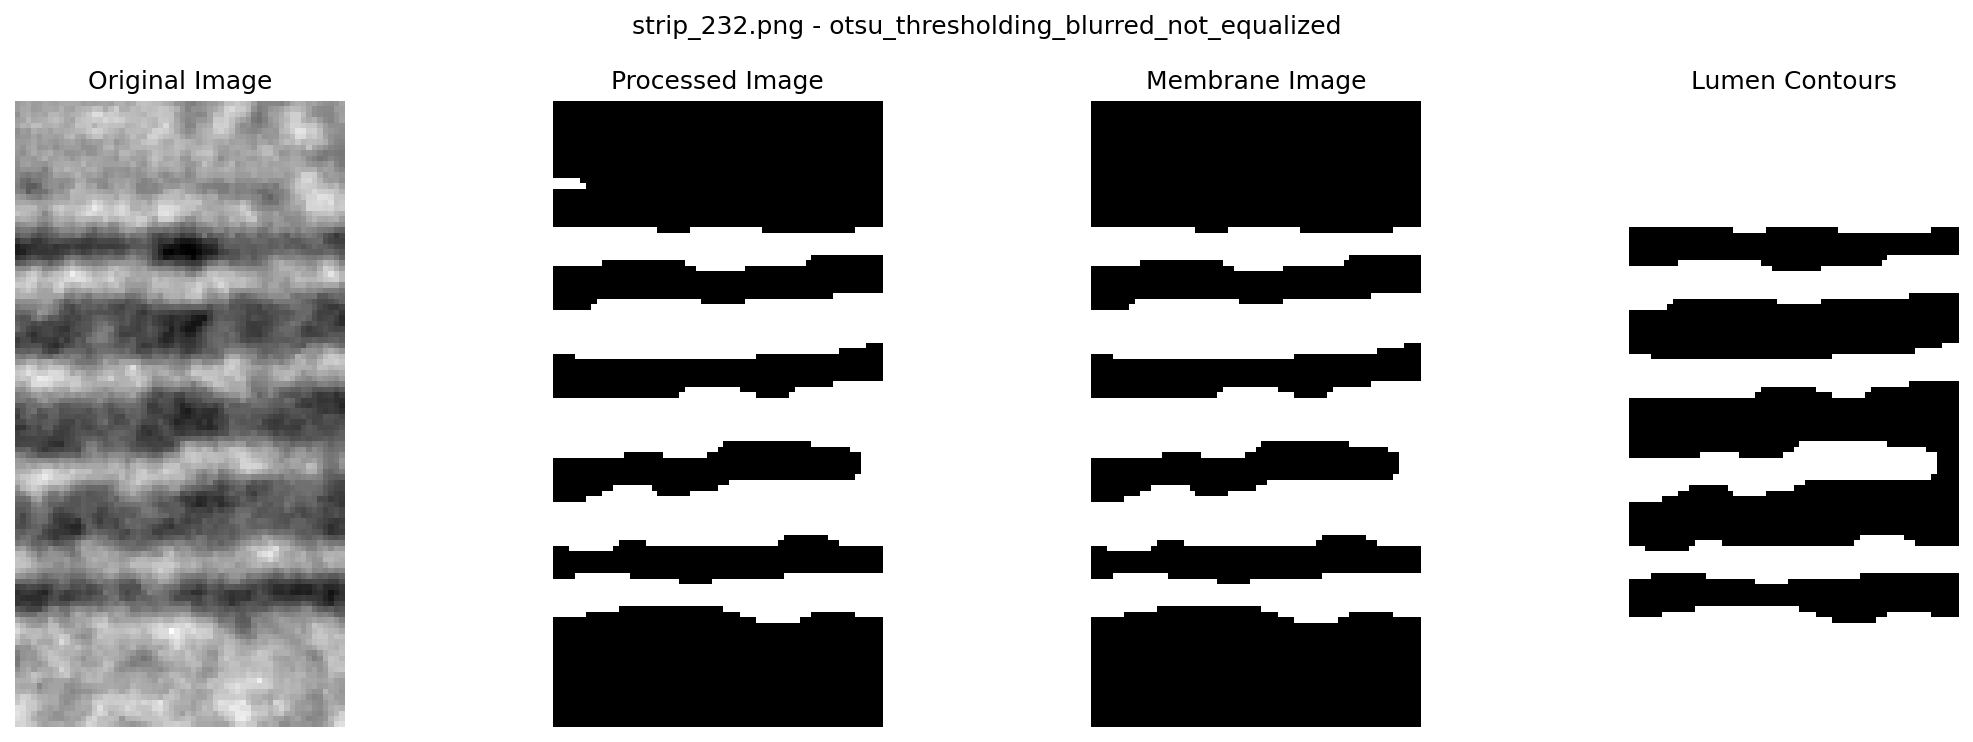

Image shape: (114, 60), Processed Image shape: (114, 60), Lumen Image shape: (114, 60), Membrane Image shape: (114, 60)


In [10]:

image, p_image, lumen_image, membrane_image = images_dict[os.path.basename(images[show_image_num])].values()

fig, ax = plt.subplots(1, 4, figsize=(15, 5), dpi=150, facecolor='w')

ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(p_image, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Processed Image')

ax[2].imshow(membrane_image, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Membrane Image')

ax[3].imshow(lumen_image, cmap='gray')
ax[3].axis('off')
ax[3].set_title('Lumen Contours')

plt.suptitle(f"{os.path.basename(image_name)} - {process_name}")
plt.tight_layout()
plt.show()
    
# printout the shapes of the various images
print(f"Image shape: {image.shape}, Processed Image shape: {p_image.shape}, Lumen Image shape: {lumen_image.shape}, Membrane Image shape: {membrane_image.shape}")

# Look at signals in the image

In [11]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths

# set the parameters of the image

strip_134.png


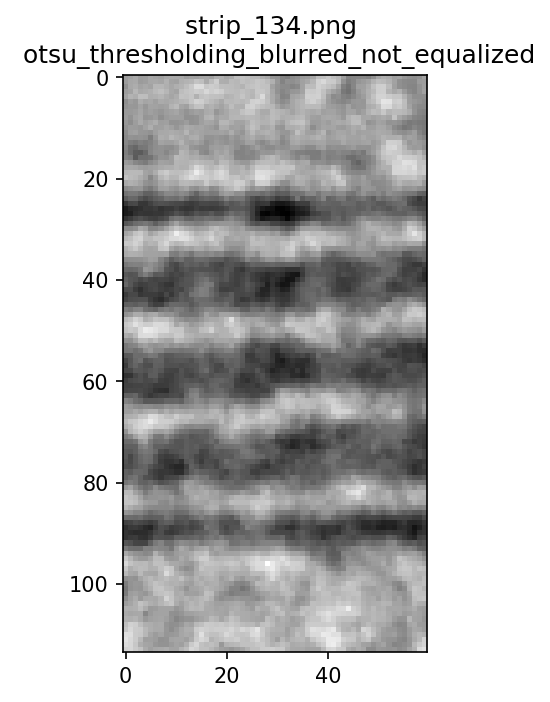

In [12]:

chosen_height = 0.5

show_image_num = 2
image, p_image, lumen_image, membrane_image = images_dict[os.path.basename(images[show_image_num])].values()
image_name = os.path.basename(images[show_image_num])

os.makedirs(f"./output/trial_{trial_number}/histograms/", exist_ok=True)

print(image_name)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150, facecolor='w')

plt.title(f"{image_name} \n {process_name}")
plt.imshow(image, cmap='gray')


# we will want to save the data for the peaks and peak_widths out to a file for later analysis
# each strip name will have a dict, in which the peaks and peak_widths will be stored
# the dicts are stored in a list, which is then saved to a pandas dataframe
data = []

# Load the conversion data from the image_conversion df

In [51]:
import pandas as pd
import os

def get_original_filename(image_name, metadata_filename):
    """
        Search the metadata file for the original filename of the image that the strip was taken from, and return it.
    """
    image_metadata = pd.read_csv(metadata_filename)
    strip_number = int(image_name.split("_")[1].split(".")[0])
    
    # if image_metadata is none, thorw an error
    if image_metadata is None:
        raise ValueError("Image metadata is None")
    
    image_df = image_metadata[image_metadata['strip'] == strip_number].to_dict(orient='records')[0]
    return image_df["filename"]


def get_image_conversion_factors(image_name:str, conversion_df_filename: str, metadata_filename: str) -> dict:
    """ 
        Returns the dict with the nm_per_pixel and pixel_per_nm values for the given image name.
    """

    image_raw_filename = get_original_filename(image_name, metadata_filename)

    conversion_df = pd.read_csv(conversion_df_filename)
    
    conversion_df['filename'] = conversion_df['filename'].map(os.path.normpath)
    
    filename = os.path.normpath(image_raw_filename)
    
    image_conversion_factors = conversion_df[conversion_df['filename'] == filename].to_dict(orient='records')[0]

    return {"nm_per_pixel": image_conversion_factors['nm_per_pixel'], "pixel_per_nm": image_conversion_factors['pixel_per_nm']}


def convert_nm_to_pixel(nm_value, nm_per_pixel):
    return nm_value / nm_per_pixel

def convert_pixel_to_nm(pixel_value, pixel_per_nm):
    return pixel_value / pixel_per_nm


In [56]:
show_image_num = 2
image_name = os.path.basename(images[show_image_num])
conversion_df_filename = "./metadata/image_scale_conversion.csv"
metadata_filename = "output/trial_1/081624_rois_metadata_bignine.csv"
image_conversion_factors = get_image_conversion_factors(image_name, conversion_df_filename, metadata_filename)
pixel_per_nm = image_conversion_factors['pixel_per_nm']
nm_per_pixel = image_conversion_factors['nm_per_pixel']
grana_height = get_human_data(image_name, human_data['data_filename'])["grana_height"]

print(f"The strip '{image_name}' comes from the raw image:\n'{image_raw_filename}'")
print(f"We can retrieve the scale conversion values:")
print(f"{nm_per_pixel} nm/px")
print(f"{pixel_per_nm} px/nm")

# look at the human data for the strip
print(f"Human-calculated grana Height: {grana_height} nm, which should be approx {convert_nm_to_pixel(grana_height, nm_per_pixel=nm_per_pixel)} px")


The strip 'strip_134.png' comes from the raw image:
'./raw_images/2023-9-4_Wild Type_Dark Adapted_3_012_25k.png'
We can retrieve the scale conversion values:
0.91324200913242 nm/px
1.095 px/nm
Human-calculated grana Height: 87.67 nm, which should be approx 95.99865000000001 px


In [57]:
show_image_num = 2
image_name = os.path.basename(images[show_image_num])
conversion_df_filename = "./metadata/image_scale_conversion.csv"
metadata_filename = "output/trial_1/081624_rois_metadata_bignine.csv"
image_conversion_factors = get_image_conversion_factors(image_name, conversion_df_filename, metadata_filename)
pixel_per_nm = image_conversion_factors['pixel_per_nm']
nm_per_pixel = image_conversion_factors['nm_per_pixel']
image, p_image, lumen_image, membrane_image = images_dict[os.path.basename(images[show_image_num])].values()
image_name = os.path.basename(images[show_image_num])

image_conversion_factors = get_image_conversion_factors(image_name, conversion_df_filename, metadata_filename)

peak_data = {}

membrane_histogram = np.sum(membrane_image, axis=1)

membrane_peaks, _ = find_peaks(membrane_histogram)

# use the peak values to calculate the full height and half height of the peaks
avg_peak_membrane = np.mean(membrane_histogram[membrane_peaks])
half_height_membrane = avg_peak_membrane * chosen_height

chosen_rel_height = half_height_membrane / avg_peak_membrane

print(f"Average peak membrane: {avg_peak_membrane}, 50% of peak: {half_height_membrane}")

# recalculate the peaks, but this time with a minimum height of 50% of the peak
# This will give us the peaks that are at least 50% of the average peak height
membrane_peaks, _ = find_peaks(membrane_histogram, height=half_height_membrane)

# how are the peak widths calculated?
results_half = peak_widths(membrane_histogram, membrane_peaks, rel_height=chosen_height)

# Returns:

#     widths
#     ndarray

#         The widths for each peak in samples.
#     width_heights
#     ndarray

#         The height of the contour lines at which the widths where evaluated.
#     left_ips, right_ips
#     ndarray

#         Interpolated positions of left and right intersection points of a horizontal line at the respective evaluation height.
widths, width_heights, left_ips, right_ips = results_half

print(f"Widths: {widths}\nWidth Heights: {width_heights}\nLeft Ips: {left_ips}\nRight Ips: {right_ips}")

# we can calculate the grana_stack_height by taking the lowest of the left_ips and the highest of the right_ips, and take the difference
grana_stack_height = np.max(right_ips) - np.min(left_ips)
print(f"Grana Stack Height: {grana_stack_height} in px, or {convert_pixel_to_nm(grana_stack_height, pixel_per_nm)} in nm")

Average peak membrane: 15300.0, 50% of peak: 7650.0
Widths: [ 6.23464373 10.49090909 10.74545455 11.16666667  6.57013575]
Width Heights: [7650. 7650. 7650. 7650. 7650.]
Left Ips: [22.81081081 35.6        52.8        69.22222222 86.07692308]
Right Ips: [29.04545455 46.09090909 63.54545455 80.38888889 92.64705882]
Grana Stack Height: 69.8362480127186 in px, or 63.77739544540511 in nm


# Plot the membrane histogram and its parameters

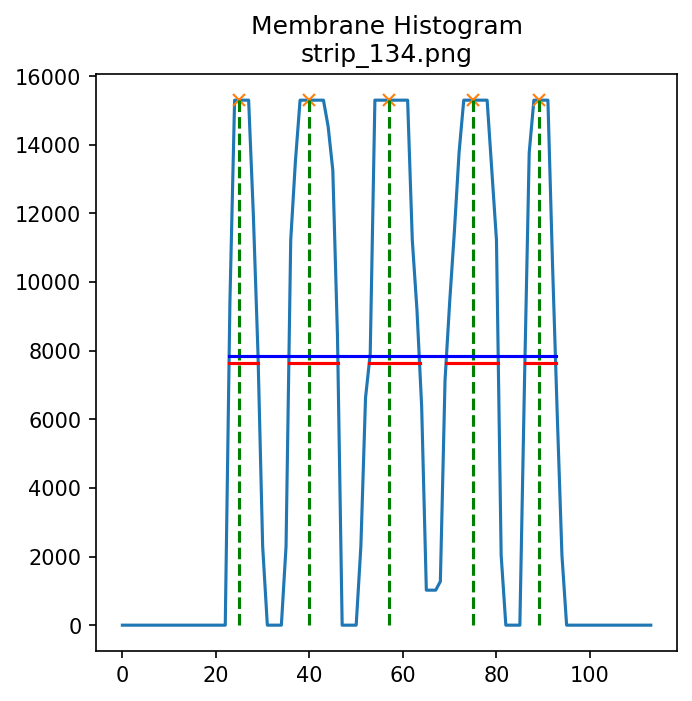

In [60]:

################ Plot it ################
# plot the histogram, but make sure the background is white
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150, facecolor='w')
plt.plot(membrane_histogram)

# plot the peaks, and then a green line dropping down
plt.plot(membrane_peaks, membrane_histogram[membrane_peaks], "x")
for peak in membrane_peaks:
    plt.plot([peak, peak], [0, membrane_histogram[peak]], "--g")
    
# use the left and right interpolated points to plot the width of the peak
for left_ip, right_ip in zip(left_ips, right_ips):
    plt.plot([left_ip, right_ip], [half_height_membrane, half_height_membrane], "-r")

# place a horizontal bar, from the left_ip to left_ip + grana_stack_height
plt.plot([np.min(left_ips), np.min(left_ips) + grana_stack_height], [half_height_membrane + 200, half_height_membrane + 200], "-b")

plt.title(f"Membrane Histogram\n{image_name}")
plt.savefig(f"./output/trial_{trial_number}/histograms/{image_name}_membrane_histogram.png")

plt.show()


# save the data for the membrane


In [19]:

peak_data["image_name"] = image_name
peak_data["membrane"] = {
    "peaks": membrane_peaks,
    "histogram": membrane_histogram,
    "peak_heights": membrane_histogram[membrane_peaks],
    "average_peak": avg_peak_membrane,
    "half_height": half_height_membrane,
    "widths": widths,
    "width_heights": width_heights,
    "left_ips": left_ips,
    "right_ips": right_ips
}


# Now move onto the lumen contours

In [ ]:
show_image_num = 2
image, p_image, lumen_image, membrane_image = images_dict[os.path.basename(images[show_image_num])].values()
image_name = os.path.basename(images[show_image_num])


# find some peaks in the histogram

lumen_histogram = np.sum(lumen_image, axis=1)

lumen_peaks, _ = find_peaks(lumen_histogram, height=1000)


avg_peak_height = np.mean(lumen_histogram[lumen_peaks])
half_height_peak = avg_peak_height * chosen_height

widths, width_heights, left_ips, right_ips = results_half

results_half = peak_widths(lumen_histogram, lumen_peaks, rel_height=chosen_height)

print(f"Widths: {widths}\nWidth Heights: {width_heights}\nLeft Ips: {left_ips}\nRight Ips: {right_ips}")


# plot the histogram, but make sure the background is white
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150, facecolor='w')

plt.plot(lumen_histogram)

plt.plot(lumen_peaks, lumen_histogram[lumen_peaks], "x")

for peak in lumen_peaks:
    # plot a vertical line at the peak, dashed green from peak to zero
    plt.plot([peak, peak], [0, lumen_histogram[peak]], "--g")
    

# use the left and right interpolated points to plot the width of the peak
for left_ip, right_ip in zip(left_ips, right_ips):
    plt.plot([left_ip, right_ip], [half_height_peak, half_height_peak], "-r")
    
plt.title(f"Lumen Histogram\n{image_name}")
plt.savefig(f"./output/trial_{trial_number}/histograms/{image_name}_lumen_histogram.png")
plt.show()

peak_data["lumen"] = {
    "peaks": lumen_peaks,
    "histogram": lumen_histogram,
    "peak_heights": lumen_histogram[lumen_peaks],
    "average_peak": avg_peak_height,
    "half_height": half_height_peak,
    "widths": widths,
    "width_heights": width_heights,
    "left_ips": left_ips,
    "right_ips": right_ips
}

data.append(peak_data)



## Outputs
Two ouput types:

### Type 1:
```
013 WT-DA-1 19k new sec strip 2
Number of peaks: 8
Average distance between peaks: 13.57
Average peak height: 15810.00
Average peak width: 0.00
Peak_num 0: peak: 5, peak_height: 15810, width: 5.27, left base: 2.18, right base: 7.45, center: 4.82
Peak_num 1: peak: 18, peak_height: 15810, width: 5.16, left base: 15.26, right base: 20.43, center: 17.84
Peak_num 2: peak: 31, peak_height: 15810, width: 4.82, left base: 28.89, right base: 33.70, center: 31.30
Peak_num 3: peak: 44, peak_height: 15810, width: 5.56, left base: 42.00, right base: 47.56, center: 44.78
Peak_num 4: peak: 59, peak_height: 15810, width: 5.00, left base: 56.69, right base: 61.69, center: 59.19
Peak_num 5: peak: 72, peak_height: 15810, width: 4.95, left base: 69.72, right base: 74.67, center: 72.20
Peak_num 6: peak: 86, peak_height: 15810, width: 5.09, left base: 83.22, right base: 88.32, center: 85.77
Peak_num 7: peak: 100, peak_height: 15810, width: 4.81, left base: 97.53, right base: 102.34, center: 99.94
```


## Type 2: derived from the first type
Use center insetad of peak, as peak is an index value, and not a real value.
Peak-to-Peak, Trough-to-Trough
Data that you van put on an excel and average:
Distance between maxima, distance between minima, and FWHM for both maxima and minima. Number of maxima. 

7 maxima-to-maxima, 6 minima-to-minima, 8 maxima FWHM, 7 minima FWHM for 8 peaks.

In [21]:
# we can use this saved data to create a pandas dataframe

In [ ]:

# what about the average distance between the peaks?
peak_distances = np.diff(lumen_peaks)
trough_distances = np.diff(membrane_peaks)
print(f"Average distance between peaks: {np.mean(peak_distances)}, average trough distance: {np.mean(trough_distances)}")

# get the half-way point between the peaks
halfway_points = membrane_peaks[:-1] + peak_distances // 2
plt.plot(halfway_points, lumen_histogram[halfway_points], "o")

# how about the full-width at half-maximum?
# we can use the peak_widths function from scipy
results = peak_widths(histogram, peaks, rel_height=chosen_height)
t_results = peak_widths(t_histogram, t_peaks, rel_height=chosen_height)
plt.hlines(*results[1:], color="C2")
plt.hlines(*t_results[1:], color="red")

plt.show()


In [ ]:

# get the half-way point between the peaks
halfway_points = peaks[:-1] + peak_distances // 2
plt.plot(halfway_points, histogram[halfway_points], "o")

# how about the full-width at half-maximum?
# we can use the peak_widths function from scipy



results = peak_widths(histogram, peaks, rel_height=chosen_height)
t_results = peak_widths(t_histogram, t_peaks, rel_height=chosen_height)
plt.hlines(*results[1:], color="C2")
plt.hlines(*t_results[1:], color="red")

plt.show()


In [ ]:
# distance between each peak
peak_distances = np.diff(peaks)
print(f"Average distance between peaks: {np.mean(peak_distances)}")

for each peak, corresponding trough? Max and min. FWHM for both peak and trough. Can just invert the image to calculate the troughs.


## Outputs
Two ouput types:

### Type 1:
013 WT-DA-1 19k new sec strip 2
Number of peaks: 8
Average distance between peaks: 13.57
Average peak height: 15810.00
Average peak width: 0.00
Peak_num 0: peak: 5, peak_height: 15810, width: 5.27, left base: 2.18, right base: 7.45, center: 4.82
Peak_num 1: peak: 18, peak_height: 15810, width: 5.16, left base: 15.26, right base: 20.43, center: 17.84
Peak_num 2: peak: 31, peak_height: 15810, width: 4.82, left base: 28.89, right base: 33.70, center: 31.30
Peak_num 3: peak: 44, peak_height: 15810, width: 5.56, left base: 42.00, right base: 47.56, center: 44.78
Peak_num 4: peak: 59, peak_height: 15810, width: 5.00, left base: 56.69, right base: 61.69, center: 59.19
Peak_num 5: peak: 72, peak_height: 15810, width: 4.95, left base: 69.72, right base: 74.67, center: 72.20
Peak_num 6: peak: 86, peak_height: 15810, width: 5.09, left base: 83.22, right base: 88.32, center: 85.77
Peak_num 7: peak: 100, peak_height: 15810, width: 4.81, left base: 97.53, right base: 102.34, center: 99.94



## Type 2: derived from the first type
Use center insetad of peak, as peak is an index value, and not a real value.
Peak-to-Peak, Trough-to-Trough
Data that you van put on an excel and average:
Distance between maxima, distance between minima, and FWHM for both maxima and minima. Number of maxima. 

7 maxima-to-maxima, 6 minima-to-minima, 8 maxima FWHM, 7 minima FWHM for 8 peaks.

## metadata
- image name
- image size
- equalize histogram parameters, clip_low, clip_high
- Otsu thresholding parameters
- contour min and max area used for thresholding
- opening and closing kernel size and iterations

and the parameters used for the peak detection.
Output the metadata in a separate file.

### Vaclav's experiment
Swelling of the lumen, in light conditions abouve a certain threshold. Has consequences for elctron transport,plastocyanin. 

Has used image j, sigmaplot. Have observed changes, in previous experiments. Significant increase in lumen, stromal gap is increasing too. Can see the diff with the naked eye, but not with sigmaplot. 

Different fixations of chloroplast and thylakoids has an impact on these parameters as well. Introduce the method, show that there are differences among the treatments. 

Later, can track light changes, and see how the lumen is changing. DIfferent paper, question. 
### methods

Measure lumen size, with FWHM of peaks. 
Measure stromal gap, distance between the base of one peaks FWHM base to the next. We do that with the inverted histogram and look at troughs.




In [ ]:

chosen_height = 0.5


# get a list of the images in our output folder. They will all have the same filename, 
# but the different processed images will be in different folders
images = glob.glob(f".\\roi_images\\*.png")

contour_image_0 = get_processed_image(images[0], trial_number, "processed_images")

# invert the contour_image_0
trough_image_0 = cv2.bitwise_not(contour_image_0)

# Lets look at the image as a histogram of where the pixels are in the y axis
# we can use np.sum to sum the pixels in the x axis
# and then plot that as a histogram
histogram = np.sum(contour_image_0, axis=1)
t_histogram = np.sum(trough_image_0, axis=1)

plt.plot(histogram)

# can we find the peaks in the histogram?
# we can use the find_peaks function from scipy
from scipy.signal import find_peaks

peaks, _ = find_peaks(histogram, height=1000)
t_peaks, _ = find_peaks(t_histogram, height=1000)

plt.plot(peaks, histogram[peaks], "x")
plt.plot(t_peaks, t_histogram[t_peaks], "x")

# what about the average distance between the peaks?
peak_distances = np.diff(peaks)
trough_distances = np.diff(t_peaks)
print(f"Average distance between peaks: {np.mean(peak_distances)}, average trough distance: {np.mean(trough_distances)}")


# get the half-way point between the peaks
halfway_points = peaks[:-1] + peak_distances // 2
plt.plot(halfway_points, histogram[halfway_points], "o")

# how about the full-width at half-maximum?
# we can use the peak_widths function from scipy
from scipy.signal import peak_widths


results = peak_widths(histogram, peaks, rel_height=chosen_height)
t_results = peak_widths(t_histogram, t_peaks, rel_height=chosen_height)
plt.hlines(*results[1:], color="C2")
plt.hlines(*t_results[1:], color="red")

plt.show()


In [ ]:
# create a function that takes an image and returns the histogram with the peaks and half-way points
from scipy.signal import find_peaks, peak_widths

def get_histogram(image_name, image, chosen_fw_height=0.5):

    # Lets look at the image as a histogram of where the pixels are in the y axis
    # we can use np.sum to sum the pixels in the x axis
    # and then plot that as a histogram
    histogram = np.sum(image, axis=1)

    # get the peaks in the histogram
    peaks, _ = find_peaks(histogram, height=1000)
    t_peaks, _ = find_peaks(t_histogram, height=1000)
    
    peak_heights = histogram[peaks]

    # what about the average distance between the peaks?
    peak_distances = np.diff(peaks)
    avg_peak_distance = np.mean(peak_distances)

    # get the half-way point between the peaks
    halfway_points = peaks[:-1] + peak_distances // 2

    # how about the full-width at half-maximum?
    # we can use the peak_widths function from scipy
    results = peak_widths(histogram, peaks, rel_height=chosen_height)
    t_results = peak_widths(t_histogram, t_peaks, rel_height=chosen_height)

    return {
        "image_name": image_name,
        "histogram": histogram,
        "peaks": peaks,
        "peak_heights": peak_heights,
        "peak_widths": peak_widths,
        "avg_peak_distance": avg_peak_distance,
        "halfway_points": halfway_points,
        "results": results,
        "t_peaks": t_peaks,
        "t_results": t_results,
    }


In [ ]:

def process_peak(peaks, results, i):
    peak = peaks[i]
    width = results[0][i]
    left_base = results[2][i]
    right_base = results[3][i]
    center = left_base + ((right_base - left_base) / 2)
    height = results[1][i]
    return {"peak_num": i, "peak": peak, "height": height, "width": float(width), "left_base": left_base, "right_base": right_base, "center": center}



In [ ]:

def get_average_peak_width(results):
    
    a = np.mean(results["results"][0]) 
    print("a: ", a)
    return a

def process_image(image):
    image_name = os.path.basename(image).split(".")[0]
    contour_image = get_processed_image(image, trial_number, "contours")
    hist_results = get_histogram(image_name, contour_image, chosen_height)
    t_hist_results = get_histogram(image_name, cv2.bitwise_not(contour_image), chosen_height)
    peak_results = [process_peak(hist_results["peaks"], hist_results["results"], i) for i in range(len(hist_results["results"][0]))]
    t_peak_results = [process_peak(t_hist_results["peaks"], t_hist_results["results"], i) for i in range(len(t_hist_results["results"][0]))]
    average_peak_height = np.mean(hist_results['peak_heights'])
    average_peak_width = get_average_peak_width(hist_results)
    average_trough_width = get_average_peak_width(t_hist_results)
    
    print(hist_results["image_name"])
    print(f"Average distance between peaks: {hist_results['avg_peak_distance']:.2f}")
    print(f"Average peak height: {average_peak_height:.2f}")
    print(f"Average peak width: {average_peak_width:.2f}")

    peak_list = []
    
    for i, both_peaks in enumerate(zip(peak_results, t_peak_results)):
        peak, t_peak = both_peaks
        peak["peak_height"] = hist_results['peak_heights'][i]
        t_peak["peak_height"] = t_hist_results['peak_heights'][i]
        
        # f"Peak_num {peak['peak_num']}: peak: {peak['peak']}, peak_height: {peak['peak_height']}, width: {peak['width']:.2f}, left base: {peak['left_base']:.2f}, right base: {peak['right_base']:.2f}, center: {peak['center']:.2f}"
        peak_dict = {"type": "peak", "num": peak['peak_num'], "peak_idx": peak['peak'], "peak_height": round(peak['peak_height'], 2), "fwhm_width": round(peak['width'], 2), "left_base": round(peak['left_base'], 2), "right_base": round(peak['right_base'], 2), "center": round(peak['center'], 2)}
        t_peak_dict = {"type": "trough", "num": t_peak['peak_num'], "peak_idx": t_peak['peak'], "peak_height": round(t_peak['peak_height'], 2), "fwhm_width": round(t_peak['width'], 2), "left_base": round(t_peak['left_base'], 2), "right_base": round(t_peak['right_base'], 2), "center": round(t_peak['center'], 2)}

        peak_list.append(peak_dict)
        peak_list.append(t_peak_dict)

    return {
        "image_name": image_name,
        "contour_image": contour_image,
        "hist_results": hist_results,
        "peak_results": peak_results,
        "average_peak_height": average_peak_height,
        "average_peak_width": average_peak_width,
        "average_trough_width": average_trough_width,
        "fwhm_dicts": peak_list
    }


In [ ]:
import pandas as pd

def display_histogram(data):
    peak_list = data["hist_results"]["peaks"].tolist()
    histogram = data["hist_results"]["histogram"]
    peak_results = data["peak_results"]
    height_th = data["average_peak_height"] * .6
    width_th = data["average_peak_width"] * .8
    
    print(f"height_th: {height_th}, width_th: {width_th}")

    # plot the bare histogram
    plt.figure(figsize=(10, 5))
    plt.title("FWHM Histogram with peak")
    plt.plot(data["hist_results"]["histogram"])

    # plot the left base, right base and center for each peak
    for peak in peak_results:
        if peak["peak_height"] > height_th and peak["width"] > width_th:
            plt.axvline(x=peak["left_base"], color='r')
            plt.axvline(x=peak["right_base"], color='r')
            plt.axvline(x=peak["center"], color='cyan')


def filter_peaks_by_height_and_width(fwhm_dicts, height_th, peak_width_th, trough_width_th):
    filtered_peaks = []
    
    # compare the peak height and width to the thresholds, for each peak and trough
    for peak in fwhm_dicts:
        if peak["peak_height"] > height_th and peak["fwhm_width"] > peak_width_th and peak["type"] == "peak":
            filtered_peaks.append(peak)
        elif peak["peak_height"] > height_th and peak["fwhm_width"] > trough_width_th and peak["type"] == "trough":
            filtered_peaks.append(peak)
            
    return filtered_peaks

def calculate_peak_to_peak_distance(df):
    """ we can calculate the distance between each peak and the next peak"""
    
    # filter the rows to only include rows that have the col "type" == "peak"
    peak_df = df[df["type"] == "peak"].copy()
    trough_df = df[df["type"] == "trough"].copy()
    
    peak_df["distance_to_next_peak"] = peak_df["center"].diff()
    trough_df["distance_to_next_peak"] = trough_df["center"].diff()
    
    df = pd.concat([peak_df, trough_df])
    print(df)

    return df

In [ ]:
import json

chosen_height = 0.5 # FWHM height, as a fraction of the peak height. 0.5 is the default
height_th_ratio = .6
width_th_ratio = .8
base_path = f"./output/trial_{trial_number}"
output_path = os.path.join(base_path, "data")
metadata_path = os.path.join(base_path, "processing_metadata.json")
print(metadata_path)

images = glob.glob(f"./output/trial_{trial_number}/strips/*.png")
hist_data = [process_image(image) for image in images]

for data in hist_data:
    # peak_list = data["hist_results"]["peaks"].tolist()
    # histogram = data["hist_results"]["histogram"]
    # peak_results = data["peak_results"]
    image_name = data["image_name"]
    fwhm_dicts = data["fwhm_dicts"]
    height_th = height_th_ratio * data["average_peak_height"]
    peak_width_th = width_th_ratio * data["average_peak_width"]
    trough_width_th = width_th_ratio * data["average_trough_width"]
    
    filtered_peaks = filter_peaks_by_height_and_width(fwhm_dicts, height_th, peak_width_th, trough_width_th)
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    df = pandas.DataFrame(filtered_peaks)

    df = calculate_peak_to_peak_distance(df)
    
    # write the dataframe out to a csv file
    df.to_csv(f"{output_path}/{image_name}_data.csv", index=False)
    
# update the metadata with the height_th and width_th_ratio
with open(metadata_path, "r") as f:
    metadata = json.load(f)
    
metadata["height_th_ratio"] = height_th_ratio
metadata["width_th_ratio"] = width_th_ratio
metadata["trial_number"] = trial_number
metadata["chosen_height"] = chosen_height

with open(metadata_path, "w") as f:
    print("writing metadata to ", metadata_path)
    json.dump(metadata, f, indent=4)

left_base,right_base,center,image_name,height_th,width_th,type,num,peak_idx,peak_height,fwhm_width


## Plot peaks and troughs on the strip images

now we need to import that data, and plot each of the peaks, and the troughs. We do that by loading the original image strip, rotating it 90 degrees, and the drawing the peak center and trough center as vertical lines on the image. 


In [ ]:

# import the images again, this time the raw image
raw_images = glob.glob(f"./output/trial_{trial_number}/strips/*.png")

# peak/trough image folder is in the "peak_trough" folder
output_path = os.path.join(base_path, "peak_trough")
print(output_path)
data_path = os.path.join(base_path, "data")

# cyan for peak color line
peak_color = (0, 255, 255)
trough_color = (255, 128, 0)

if not os.path.exists(output_path):
    os.makedirs(output_path)

print(len(raw_images))

for image in raw_images:
    raw_image = get_processed_image(image, trial_number, "strips")
    print(raw_image.shape)
    
    # rotate the image 90 degrees counter-clockwise
    raw_image = cv2.rotate(raw_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    # convert it to an rgb image from grayscale
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_GRAY2RGB)
    
    # get the base name of the image, strip out the png, and then use that to load the csv file
    image_name = os.path.basename(image).split(".")[0]
    df = pd.read_csv(f"{data_path}/{image_name}_data.csv")
    
    print(image_name)
    print(df.shape)
    print(raw_image.shape)
    
    peak_df = df[df["type"]=="peak"]
    trough_df = df[df["type"]=="trough"]

    
    for center in peak_df["center"]:
        cv2.line(raw_image, (int(center), 0), (int(center), raw_image.shape[0]), peak_color, 1)
    
    # add a vertical line to the image for each trough
    for center in trough_df["center"]:
        cv2.line(raw_image, (int(center), 0), (int(center), raw_image.shape[0]), trough_color, 1)
    
    plt.title(f"{image_name} with peaks and troughs")
    
    # get rid of the axes and all of that
    plt.imshow(raw_image, cmap="viridis")
    plt.axis("off")
    plt.imsave(f"{output_path}/{image_name}.png", raw_image)



# Create image dict
We need to create an image dict, with the image name as the key, and the value being a dict with the following keys:
raw_image: the original image
thresholded: the thresholded image
contours: the contours image
overlay: the overlay image
peak_trough: the peak and trough image

In [ ]:
def create_image_dict(image_name, base_path=f"./output/trial_{trial_number}"):
    def get_abs_path(image_type):
        return os.path.abspath(f"{base_path}/{image_type}/{image_name}.png")
    
    return {
        "raw": get_abs_path("strips"),
        "equalized": get_abs_path("equalized"),
        "thresholded": get_abs_path("thresholded"),
        "contours": get_abs_path("contours"),
        "overlay": get_abs_path("overlay"),
        "peak_trough": get_abs_path("peak_trough")
    }

image_names = [os.path.basename(image).split(".")[0] for image in images]

image_paths = {f"{image_name}": create_image_dict(image_name) for image_name in image_names}
    

In [ ]:
import cv2
import np as np

def add_horizontal_peak_trough_lines(image, csv_path, peak_color=(255, 128, 0), trough_color=(0, 255, 255), alpha=0.5, width=10):
    df = pd.read_csv(csv_path)
    peak_df = df[df["type"]=="peak"]
    trough_df = df[df["type"]=="trough"]

    # Create a copy of the original image to draw lines on
    line_image = image.copy()

    for center in peak_df["center"]:
        # add a horizontal line at the y coordinate center
        cv2.line(line_image, (0, int(center)), (line_image.shape[1], int(center)), peak_color, width)

    for center in trough_df["center"]:
        # add a horizontal line at the y coordinate center
        cv2.line(line_image, (0, int(center)), (line_image.shape[1], int(center)), trough_color, width)

    # Blend the original image with the line image
    cv2.addWeighted(line_image, alpha, image, 1 - alpha, 0, image)

    return image

def load_rgb_image(image_path):
    bgr_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    return rgb_image

## Create a comparison image
We need to see a comparison of all the iamges we have created so far


In [ ]:
import os
import np as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming the functions `load_rgb_image` and `add_horizontal_peak_trough_lines` are defined elsewhere

# Set the paths
output_path = os.path.join(base_path, "peak_trough")
data_path = os.path.join(base_path, "data")
line_alpha = 0.8
line_width = 1
peak_color = (255, 128, 0)
trough_color = (0, 255, 255)

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# List to store all processed images
all_images = []
titles = []

# Process each image and store the results
for image in image_paths:
    csv_path = f"{data_path}/{image}_data.csv"
    print(csv_path)

    # Load images as color images
    raw_image = load_rgb_image(image_paths[image]["raw"])
    equalized_image = load_rgb_image(image_paths[image]["equalized"])
    thresholded_image = load_rgb_image(image_paths[image]["thresholded"])
    contours_image = load_rgb_image(image_paths[image]["contours"])

    # Add horizontal peak and trough lines
    raw_image = add_horizontal_peak_trough_lines(raw_image, csv_path, peak_color=peak_color, trough_color=trough_color, alpha=line_alpha, width=line_width)
    equalized_image = add_horizontal_peak_trough_lines(equalized_image, csv_path, peak_color=peak_color, trough_color=trough_color, alpha=line_alpha, width=line_width)
    thresholded_image = add_horizontal_peak_trough_lines(thresholded_image, csv_path, peak_color=peak_color, trough_color=trough_color, alpha=line_alpha, width=line_width)
    contours_image = add_horizontal_peak_trough_lines(contours_image, csv_path, peak_color=peak_color, trough_color=trough_color, alpha=line_alpha, width=line_width)

    # Append images and titles to lists
    all_images.append([raw_image, equalized_image, thresholded_image, contours_image])
    titles.append(f"{image} peaks and troughs")

# Calculate the size of the figure
fig_width = raw_image.shape[1] / 20
fig_height = raw_image.shape[0] / 20


# Plot all the images in a single figure with multiple rows and 4 columns
num_rows = len(image_paths)
fig, axes = plt.subplots(num_rows, 4, figsize=(fig_width * 4, fig_height * num_rows), facecolor='white')

for row, images in enumerate(all_images):
    for col, img in enumerate(images):
        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        if row == 0:
            if col == 0:
                axes[row, col].set_title("raw")
            elif col == 1:
                axes[row, col].set_title("equalized")
            elif col == 2:
                axes[row, col].set_title("thresholded")
            elif col == 3:
                axes[row, col].set_title("contours")

# Add a legend for peak and trough colors
peak_patch = Patch(color=tuple(np.array(peak_color) / 255), label='peak')
trough_patch = Patch(color=tuple(np.array(trough_color) / 255), label='trough')
fig.legend(handles=[peak_patch, trough_patch], bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top to make room for the titles
fig.suptitle("Peaks and Troughs in Images")

# Save the combined figure
plt.savefig(f"./report/peak_troughs.png")
plt.show()

In [ ]:
# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch

# output_path = os.path.join(base_path, "peak_trough")
# data_path = os.path.join(base_path, "data")
# line_alpha = 0.8
# line_width = 1
# peak_color=(255, 128, 0)
# trough_color=(0, 255, 255)

# #create the directory if it doesn't exist
# if not os.path.exists(output_path):
#     os.makedirs(output_path)

# for image in image_paths:
#     csv_path = f"{data_path}/{image}_data.csv"
#     print(csv_path)
    
#     # load as color images
#     raw_image = load_rgb_image(image_paths[image]["raw"])
#     equalized_image = load_rgb_image(image_paths[image]["equalized"])
#     thresholded_image = load_rgb_image(image_paths[image]["thresholded"])
#     contours_image = load_rgb_image(image_paths[image]["contours"])
#     overlay_image = load_rgb_image(image_paths[image]["overlay"])
    
#     # calculate the size of the figure
#     fig_width = raw_image.shape[1] / 5
#     fig_height = raw_image.shape[0] / 25
#     print(f"fig_height: {fig_height}")
#     # create a plot with subplots for all of the images so we can compare them
#     fig, axs = plt.subplots(1, 4, figsize=(fig_width, fig_height))
#     plt.subplots_adjust(top=0.85)  # Adjust the top of the figure to make room for the suptitle
#     fig.suptitle(f"{image} peaks and troughs")
    

#     raw_image = add_horizontal_peak_trough_lines(raw_image, csv_path, peak_color=peak_color, trough_color=trough_color, alpha=line_alpha, width=line_width)
#     axs[0].imshow(raw_image, cmap="gray")
#     axs[0].set_title("raw")
#     axs[0].axis("off")

#     equalized_image = add_horizontal_peak_trough_lines(raw_image, csv_path,peak_color=peak_color, trough_color=trough_color,  alpha=line_alpha, width=line_width)
#     axs[1].imshow(equalized_image, cmap="gray")
#     axs[1].set_title("equalized")
#     axs[1].axis("off")

#     thresholded_image = add_horizontal_peak_trough_lines(thresholded_image, csv_path,peak_color=peak_color, trough_color=trough_color,  alpha=line_alpha, width=line_width)
#     axs[2].imshow(thresholded_image, cmap="gray")
#     axs[2].set_title("thresholded")
#     axs[2].axis("off")

#     contours_image = add_horizontal_peak_trough_lines(contours_image, csv_path,peak_color=peak_color, trough_color=trough_color,  alpha=line_alpha, width=line_width)
#     axs[3].imshow(contours_image, cmap="gray")
#     axs[3].set_title("contours")
#     axs[3].axis("off")

#     # add a legend showing that the peak_color has a label "peak" and the trough_color has a label "trough"
#     peak_patch = Patch(color=tuple(np.array(peak_color)/255), label='peak')
#     trough_patch = Patch(color=tuple(np.array(trough_color)/255), label='trough')
#     plt.legend(handles=[peak_patch, trough_patch], bbox_to_anchor=(1.05, 0.5), loc='center left')

#     plt.tight_layout()
#     # save it to the comparison2 folder
#     plt.savefig(f"{output_path}/{image}.png")
#     plt.show()

# now lets do something similar with the FWHM for both peaks and troughs


In [ ]:
import cv2
import numpy as np

def add_fwhm_boxes(image, csv_path, peak_color=(255, 128, 0), trough_color=(0, 255, 255), alpha=0.2):
    df = pd.read_csv(csv_path)
    peak_df = df[df["type"]=="peak"]
    trough_df = df[df["type"]=="trough"]

    # Create a copy of the original image to draw lines on
    overlay = image.copy()
    
    print(f"image y = {image.shape[0]}, image x = {image.shape[1]}")
    
    for index, row in df.iterrows():
        top_y = int(row["left_base"])
        bottom_y = int(row["right_base"])
        print(f"top_y: {top_y}, bottom_y: {bottom_y}")
        box_color = peak_color if row["type"] == "peak" else trough_color
        cv2.rectangle(overlay, (0, top_y), (image.shape[1], bottom_y), box_color, -1)

    # Blend the original image with the line image
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    return image
    


In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

output_path = os.path.join(base_path, "fwhm_comparison")
data_path = os.path.join(base_path, "data")
line_alpha = 0.2
peak_color=(255, 128, 0)
trough_color=(0, 255, 255)

#create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

for image in image_paths:
    csv_path = f"{data_path}/{image}_data.csv"
    print(csv_path)
    
    # load as color images
    raw_image = load_rgb_image(image_paths[image]["raw"])
    equalized_image = load_rgb_image(image_paths[image]["equalized"])
    thresholded_image = load_rgb_image(image_paths[image]["thresholded"])
    contours_image = load_rgb_image(image_paths[image]["contours"])
    
    # calculate the size of the figure
    fig_width = raw_image.shape[1] / 5
    fig_height = raw_image.shape[0] / 25
    print(f"fig_height: {fig_height}")
    # create a plot with subplots for all of the images so we can compare them
    fig, axs = plt.subplots(1, 4, figsize=(fig_width, fig_height), facecolor='white')
    plt.subplots_adjust(top=0.85)  # Adjust the top of the figure to make room for the suptitle
    fig.suptitle(f"{image} peaks and troughs")
    

    raw_image = add_fwhm_boxes(raw_image, csv_path, peak_color=peak_color, trough_color=trough_color, alpha=line_alpha)
    axs[0].imshow(raw_image, cmap="gray")
    axs[0].set_title("raw")
    axs[0].axis("off")

    equalized_image = add_fwhm_boxes(raw_image, csv_path,peak_color=peak_color, trough_color=trough_color,  alpha=line_alpha)
    axs[1].imshow(equalized_image, cmap="gray")
    axs[1].set_title("equalized")
    axs[1].axis("off")

    thresholded_image = add_fwhm_boxes(thresholded_image, csv_path,peak_color=peak_color, trough_color=trough_color,  alpha=line_alpha)
    axs[2].imshow(thresholded_image, cmap="gray")
    axs[2].set_title("thresholded")
    axs[2].axis("off")

    contours_image = add_fwhm_boxes(contours_image, csv_path,peak_color=peak_color, trough_color=trough_color,  alpha=line_alpha)
    axs[3].imshow(contours_image, cmap="gray")
    axs[3].set_title("contours")
    axs[3].axis("off")

    # add a legend showing that the peak_color has a label "peak" and the trough_color has a label "trough"
    peak_patch = Patch(color=tuple(np.array(peak_color)/255), label='peak')
    trough_patch = Patch(color=tuple(np.array(trough_color)/255), label='trough')
    plt.legend(handles=[peak_patch, trough_patch], bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout()
    # save it to the comparison2 folder
    plt.savefig(f"{output_path}/{image}.png")
    plt.show()
    


In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

output_path = os.path.join(base_path, "comparison2")
data_path = os.path.join(base_path, "data")
line_alpha = 0.8
line_width = 1
peak_color=(255, 128, 0)
trough_color=(0, 255, 255)

#create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

for image in image_paths:
    csv_path = f"{data_path}/{image}_data.csv"
    print(csv_path)
    
    # load as color images
    raw_image = load_rgb_image(image_paths[image]["raw"])
    equalized_image = load_rgb_image(image_paths[image]["equalized"])
    thresholded_image = load_rgb_image(image_paths[image]["thresholded"])
    contours_image = load_rgb_image(image_paths[image]["contours"])
    overlay_image = load_rgb_image(image_paths[image]["overlay"])
    
    # calculate the size of the figure
    fig_width = raw_image.shape[1] / 5
    fig_height = raw_image.shape[0] / 25
    print(f"fig_height: {fig_height}")
    # create a plot with subplots for all of the images so we can compare them
    fig, axs = plt.subplots(1, 4, figsize=(fig_width, fig_height), facecolor='white')
    plt.subplots_adjust(top=0.85)  # Adjust the top of the figure to make room for the suptitle
    fig.suptitle(f"{image} peaks and troughs")
    

    raw_image = add_horizontal_peak_trough_lines(raw_image, csv_path, peak_color=peak_color, trough_color=trough_color, alpha=line_alpha, width=line_width)
    axs[0].imshow(raw_image, cmap="gray")
    axs[0].set_title("raw")
    axs[0].axis("off")

    equalized_image = add_horizontal_peak_trough_lines(raw_image, csv_path,peak_color=peak_color, trough_color=trough_color,  alpha=line_alpha, width=line_width)
    axs[1].imshow(equalized_image, cmap="gray")
    axs[1].set_title("equalized")
    axs[1].axis("off")

    thresholded_image = add_horizontal_peak_trough_lines(thresholded_image, csv_path,peak_color=peak_color, trough_color=trough_color,  alpha=line_alpha, width=line_width)
    axs[2].imshow(thresholded_image, cmap="gray")
    axs[2].set_title("thresholded")
    axs[2].axis("off")

    contours_image = add_horizontal_peak_trough_lines(contours_image, csv_path,peak_color=peak_color, trough_color=trough_color,  alpha=line_alpha, width=line_width)
    axs[3].imshow(contours_image, cmap="gray")
    axs[3].set_title("contours")
    axs[3].axis("off")

    # add a legend showing that the peak_color has a label "peak" and the trough_color has a label "trough"
    peak_patch = Patch(color=tuple(np.array(peak_color)/255), label='peak')
    trough_patch = Patch(color=tuple(np.array(trough_color)/255), label='trough')
    plt.legend(handles=[peak_patch, trough_patch], bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout()
    # save it to the comparison2 folder
    plt.savefig(f"{output_path}/{image}.png")
    plt.show()
    


In [ ]:
# chosen_height = 0.5 # FWHM height, as a fraction of the peak height. 0.5 is the default

# images = glob.glob(f"./output/strips/*.png")
# hist_data = [process_image(image) for image in images]


In [ ]:
# # what do the various results [i] mean?
# # results[0] = widths
# # results[1] = peak_heights
# # results[2] = left_bases
# # results[3] = right_bases

# # convert the peaks to a list for easier access
# peak_list = peaks.tolist()

# # plot the bare histogram
# plt.figure(figsize=(10, 5))
# plt.title("Histogram")
# plt.plot(histogram)

# # plot the histogram again, and this time put a vertical line at the left base and the 
# # right base of each of the peaks, and a centerline
# plt.plot(peaks, histogram[peaks], "x", figure=plt.figure(figsize=(10, 5)))
# for i, peak in enumerate(peak_list):

#     width = results[0][i]
#     peak_height = results[1][i]
#     fwheight = results[1][i]
#     left_base = results[2][i]
#     right_base = results[3][i]
#     center = left_base + ((right_base - left_base) / 2)

#     print(f"Peak {i}:")
#     print(f"Peak height: {peak_height}")
#     print(f"FWHeight: {fwheight:.2f}")
#     print(f"Width: {width:.2f}")
#     print(f"Left base: {left_base:.2f}")
#     print(f"Right base: {right_base:.2f}")
#     print(f"Center: {center:.2f}")
#     print("\n")

#     plt.axvline(x=results[2][i], color='r')
#     plt.axvline(x=results[3][i], color='r')
    
#     results = peak_widths(histogram, peaks, rel_height=chosen_height)
#     plt.hlines(*results[1:], color="C2")

#     # calculate the center of the full-width at half-maximum
#     # center = results[3][i] - int((results[3][i] - results[2][i]) // 2)
#     plt.axvline(x=center, color='cyan')
#     # plot a dot at the (center, *results[1:])
#     plt.plot(center, results[1][i], "o")

# plt.plot(histogram)
# # plt.plot(peaks,[0, 0, 0, 0, 0, 0, 0, 0], "x") # peaks is the x axis, so we need to plot the y axis at 0 to show the 'x' marker at the peak position at the bottom of the graph
# plt.show()


### Type 1:
013 WT-DA-1 19k new sec strip 2
Number of peaks: 8
Average distance between peaks: 13.57
Average peak height: 15810.00
Average peak width: 0.00
Peak_num 0: peak: 5, peak_height: 15810, width: 5.27, left base: 2.18, right base: 7.45, center: 4.82
Peak_num 1: peak: 18, peak_height: 15810, width: 5.16, left base: 15.26, right base: 20.43, center: 17.84
Peak_num 2: peak: 31, peak_height: 15810, width: 4.82, left base: 28.89, right base: 33.70, center: 31.30
Peak_num 3: peak: 44, peak_height: 15810, width: 5.56, left base: 42.00, right base: 47.56, center: 44.78
Peak_num 4: peak: 59, peak_height: 15810, width: 5.00, left base: 56.69, right base: 61.69, center: 59.19
Peak_num 5: peak: 72, peak_height: 15810, width: 4.95, left base: 69.72, right base: 74.67, center: 72.20
Peak_num 6: peak: 86, peak_height: 15810, width: 5.09, left base: 83.22, right base: 88.32, center: 85.77
Peak_num 7: peak: 100, peak_height: 15810, width: 4.81, left base: 97.53, right base: 102.34, center: 99.94

In [ ]:

# for data in hist_data:
#     display_histogram(data)
#     plt.show()
                    
                    
# data = hist_data[0]
# peak_list = data["hist_results"]["peaks"].tolist()
# histogram = data["hist_results"]["histogram"]
# peak_results = data["peak_results"]

# # plot the bare histogram
# plt.figure(figsize=(10, 5))
# plt.title("FWHM Histogram with peak")
# plt.plot(data["hist_results"]["histogram"])

# # plot the left base, right base and center for each peak
# for peak in peak_results:
#     plt.axvline(x=peak["left_base"], color='r')
#     plt.axvline(x=peak["right_base"], color='r')
#     plt.axvline(x=peak["center"], color='cyan')

In [ ]:
# #get the contour image 
# contour_image_0 = get_processed_image(images[0], "contours")

# # get the shape of the image
# height, width = contour_image_0.shape
# print(f"Image shape: {height}x{width}")
# # given a contour image, we want to divide it into a given number of vertical strips.
# # to do this, we need to divide the width of the image by the number of strips we want
# # and then take the vertical subset of the image for each of those x value ranges
# num_strips = 10

# # the width of each strip is the width of the image divided by the number of strips, rounded down to the nearest integer
# strip_width = width // num_strips
# print(f"Strip width: {strip_width}")

# # for each image, we want to divide it into vertical strips, of a certain width. Then 
# # add that to a list of strips.

# strips = []

# for i in range(0, num_strips):

#     x = i * strip_width
#     print(f"Strip {x}:{x + strip_width}")
#     strip = contour_image_0[:, x:x+strip_width]
#     strips.append(strip)

# print(f"Number of strips: {len(strips)}")

# # Lets display each as a subplot in a single figure
# # create the base plot
# fig, axs = plt.subplots(1, num_strips, figsize=(5, 5))

# # for each strip, display it in a subplot
# for i, strip in enumerate(strips):
#     axs[i].imshow(strip, cmap='inferno')
#     axs[i].set_title(f"{i}", size=8)
#     axs[i].axis('off')
    
# plt.suptitle(f"num_strips={num_strips}, strip_width={strip_width}", size=12)
# plt.show()


In [ ]:
# # for each strip in strips, we want to contours using cv2.findContours
# # we will then store the contours in a list of lists
# contours = []

# for strip in strips:
#     # find the contours in the strip
#     cnts, _ = cv2.findContours(strip, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours.append(cnts)
    
# # lets look at the coordinates for the first contour in the first strip
# print(contours[0][0])

# # can we get a centroid for the first contour in the first strip?
# M = cv2.moments(contours[0][0])

# # calculate x,y coordinate of center
# cX = int(M["m10"] / M["m00"])
# cY = int(M["m01"] / M["m00"])

# print(f"Centroid: {cX}, {cY}")